# NB03 &ndash; Wideband filtering via FFT

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Filtering-out-power-grid-noise" data-toc-modified-id="Filtering-out-power-grid-noise-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Filtering out power grid noise</a></span><ul class="toc-item"><li><span><a href="#Prepare-data" data-toc-modified-id="Prepare-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Prepare data</a></span></li><li><span><a href="#Auxiliary-functions" data-toc-modified-id="Auxiliary-functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Auxiliary functions</a></span></li><li><span><a href="#Plotting-original-signal-and-its-FFT" data-toc-modified-id="Plotting-original-signal-and-its-FFT-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Plotting original signal and its FFT</a></span></li><li><span><a href="#Filtering-out-frequencies-by-&quot;copying-and-pasting&quot;" data-toc-modified-id="Filtering-out-frequencies-by-&quot;copying-and-pasting&quot;-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Filtering out frequencies by "copying and pasting"</a></span></li><li><span><a href="#Plotting-the-filtered-signal-and-its-FFT" data-toc-modified-id="Plotting-the-filtered-signal-and-its-FFT-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Plotting the filtered signal and its FFT</a></span></li></ul></li><li><span><a href="#Notes" data-toc-modified-id="Notes-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Notes</a></span></li><li><span><a href="#References" data-toc-modified-id="References-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Setup

In [1]:
%matplotlib inline

import ipywidgets as ipw
import matplotlib.pyplot as plt
import numpy as np

from facades import *
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from typing import List, Tuple

## Filtering out power grid noise

Let's filter out the power grid frequency components, like 60 Hz and its harmonics.

### Prepare data

In [2]:
recording_name = "grating-v206-he1800-hd2600"
channel = 29

In [3]:
recording = RecordingFacade.load(recording_name)
wb = recording.slow_channel(channel, SlowChannelType.WB)
signal_samples = wb.total_samples
signal_time = wb.total_time
sampling_rate = wb.sampling_rate

Memory-mapped arrays for original signal, its FFT, and the filtered version:

In [4]:
template_path = f'data/{recording_name}/slow_data/wb{channel:02d}%s.npy'

wb_original = np.memmap(template_path % '_original', dtype='f4', shape=(wb.total_samples), mode='w+')
wb_fft = np.memmap(template_path % '_fft', dtype='c8', shape=(wb.total_samples), mode='w+')
wb_filtered = np.memmap(template_path % '_filtered', dtype='f4', shape=(wb.total_samples), mode='w+')

Store the denormalized signal into the memory-mapped array:

In [5]:
wb_original[:] = wb.signal

Then, compute its FFT:

In [6]:
wb_fft[:] = fft(wb_original)

### Auxiliary functions

In [7]:
def freq_sample(F):
    k = int(np.round(signal_samples * (F / sampling_rate)))
    return k

In [8]:
def time_sample(T):
    k = int(np.round(T * sampling_rate))
    return k

### Plotting original signal and its FFT

In [9]:
def plot_signal(signal, seconds, overlay_frequencies=[]):
    samples = time_sample(seconds)
    
    x = np.linspace(0, seconds, samples)
    y = signal[:samples]
    y_baseline = np.mean(y)
    y_amplitude = np.max(y) - np.min(y)
    
    
    plt.figure(figsize=(12, 4))
    plt.plot(x, y, label='Signal')
    plt.grid()
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (mV)')
    
    for freq in overlay_frequencies:
        plt.plot(x, y_baseline + 0.5 * y_amplitude * np.sin(2 * np.pi * freq * x), label=f'{freq} Hz')

Plotting up to a frequency of 1 KHz:

In [10]:
def plot_fft(signal, f0, f1, log=True):
    k0 = freq_sample(f0)
    k1 = freq_sample(f1)
    
    xf = np.linspace(f0, f1, k1-k0)
    yf = signal[k0:k1]

    plt.figure(figsize=(12, 4))
    plt.plot(xf, np.abs(yf))
    plt.xlim(f0, f1)
    if log:
        plt.yscale('log')
        plt.ylabel('Voltage PSD (log mV)')
    else:
        plt.ylabel('Voltage PSD (mV)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Voltage PSD (log mV)')
    plt.grid()

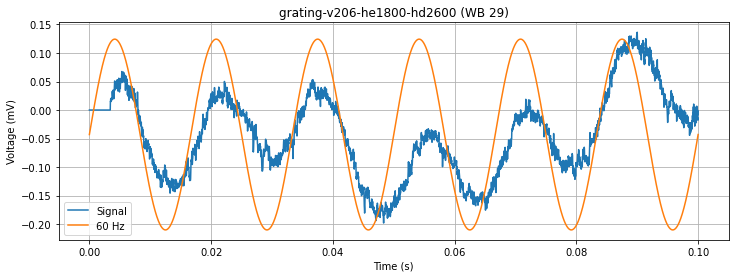

In [11]:
plot_signal(wb_original, 0.1, [60])
plt.title(f'{recording_name} (WB {channel})')
plt.legend();

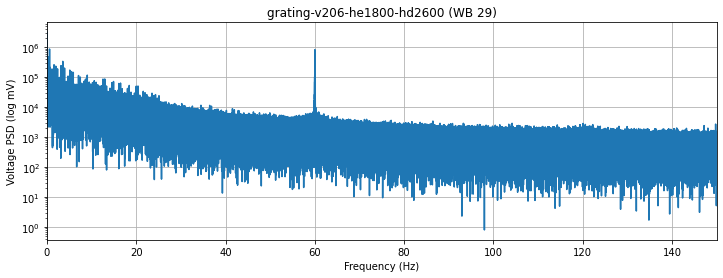

In [12]:
plot_fft(wb_fft, 0, 150)
plt.title(f'{recording_name} (WB {channel})');

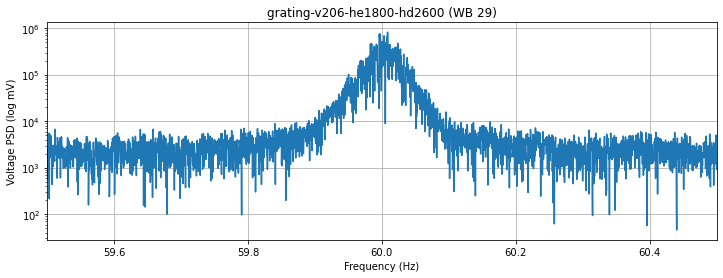

In [13]:
plot_fft(wb_fft, 59.5, 60.5)
plt.title(f'{recording_name} (WB {channel})');

### Filtering out frequencies by "copying and pasting"

In [14]:
def filter_freq_interp(yf, frequency, radius, margin=None):
    if frequency < 0:
        frequency = sampling_rate + frequency
        
    if margin is None:
        margin = 2 * radius
        
    k0 = freq_sample(frequency - radius - margin)
    k1 = freq_sample(frequency - radius)
    k2 = freq_sample(frequency + radius)
    k3 = freq_sample(frequency + radius + margin)
    
    yfi = interp1d(
        np.hstack((np.arange(k0, k1), np.arange(k2, k3))),
        np.hstack((yf[k0:k1], yf[k2:k3])),
    )
        
    yf[k1:k2] = yfi(np.arange(k1, k2))

In [15]:
def filter_freq_template(yf, frequency, radius):
    if frequency < 0:
        frequency = sampling_rate + frequency
        
    kr = freq_sample(radius)
    kc = freq_sample(frequency)
        
    k0 = kc - 3 * kr
    k1 = kc - kr
    k2 = kc + kr
    k3 = kc + 3 * kr
    
    yf[k1:k2] = 0.5 * (yf[k0:k1] + yf[k2:k3])

In [16]:
for freq in [60, 120, 180, 240, 300]:
    filter_freq_template(wb_fft, freq, radius=0.5)
    filter_freq_template(wb_fft, -freq, radius=0.5)

In [17]:
wb_filtered[:] = np.real(ifft(wb_fft))

### Plotting the filtered signal and its FFT

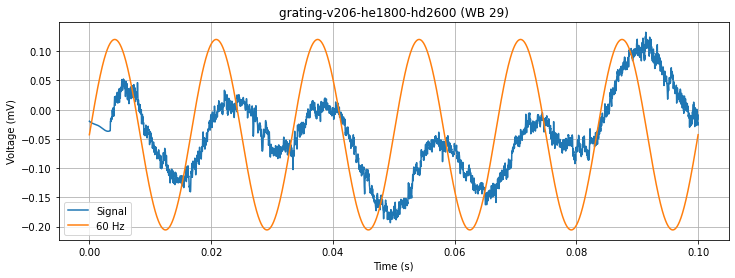

In [18]:
plot_signal(wb_filtered, 0.1, [60])
plt.title(f'{recording_name} (WB {channel})')
plt.legend();

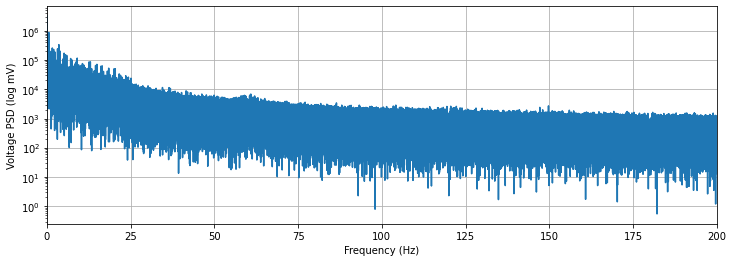

In [19]:
plot_fft(wb_fft, 0, 200)

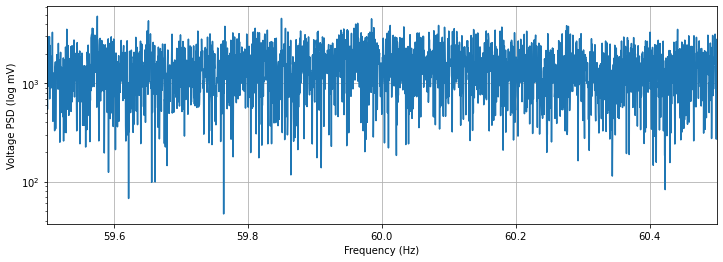

In [20]:
plot_fft(wb_fft, 59.5, 60.5)

## Notes

According to [scipy's manual](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html), the FFT function produces the following output array $y$, given input $x$:

$y[k] = \sum_\limits{n=0}^{N-1} x[k] \exp\left\{-2i\pi \frac{nk}{N} \right\}$

The output indices correspond to frequencies $f$ that are relative to the signal duration.
In other words, $f = k/n$, where $f \in [0, 1]$.
These "signal-space" frequencies relate to the actual sampling frequencies $F \in [0, 40000]~{\rm Hz}$ as $f = \frac{F}{40000~{\rm Hz}}$.
Therefore, the sample corresponding to a frequency of $F$ is

$$k = \frac{FN}{40000~{\rm Hz}}$$

## References

* [OmniPlex Manual](https://plexon.com/wp-content/uploads/2020/01/OmniPlex-User-Guide.pdf)
* [Spectral leakage and zero-padding of the DFT](https://dspillustrations.com/pages/posts/misc/spectral-leakage-zero-padding-and-frequency-resolution.html)